# Gantt chart stand allocation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import openpyxl
import numpy as np
import sys
from pylab import *
%matplotlib inline

In [68]:
# TO DO: - make it work with multiple days, exporting gantt charts for each day
#        - different stand groups
#        - label flight
#        - colour by airline

In [2]:
# Import linked flights
data_path = os.path.join(os.getcwd(), 'output', 'turnarounds.csv')
linked = pd.read_csv(data_path)

# Convert datetimes to datetime format (currently string)
linked.DATETIME_x = pd.to_datetime(linked.DATETIME_x)
linked.DATETIME_y = pd.to_datetime(linked.DATETIME_y)

# Import solution from xpress
data_path = os.path.join(os.getcwd(), 'output', 'solution.txt')
allocation  = pd.read_csv(data_path, sep=" ", header=None)
allocation.columns = ["arrFlight", "stand"]

In [3]:
# Open excel file
data_path = os.path.join(os.getcwd(), 'data', 'standAllocationMaster.xlsx')
wb = openpyxl.load_workbook(data_path)

# Save first sheet with stand data
standsSheet = wb['Stands']

# Read stands from column D in stand sheet
stands      = []
standGroups = []

# Read each stand and stand group and store in separate lists
for row in range(3,200):
    thisStand      = standsSheet.cell(row=row, column=4).value
    thisStandGroup = standsSheet.cell(row=row, column=2).value
    
    # continue until there are no more stands
    if thisStand == None: break
    stands.     append(thisStand)
    standGroups.append(thisStandGroup)
    
stands_dict = dict(zip(stands, standGroups))

In [4]:
if all(linked.SERVICE_x != allocation.arrFlight):
    print('error: flights in turnarounds.csv do not match flights in solution.txt')
    sys.exit()

# Add column with allocated stand
linked['stand']       = allocation['stand']
linked['stand_group'] = [stands_dict[stand] for stand in allocation['stand']]

Timestamp('2018-04-09 00:00:00')

In [5]:
# Array of unique groups of stands
unique_groups = np.unique(standGroups)

# For each stand group, extract a subset of the dataframe of turnarounds
subsets = []
for group in unique_groups:
    #idx = [standGroups[np.where(np.array(stands) == stand)[0][0]] == group for stand in allocation.stand]
    subsets.append(linked[linked['stand_group'] ==  group])

# Create a dictionary with dataframes as values, stand groups as keys    
allocation_groups = dict(zip(unique_groups, subsets))

### Test gantt chart with one group

In [32]:
testGroup = 'SOUTH EAST REMOTE APRON'
testFlights = allocation_groups[testGroup]
testStands = np.array(stands)[[group == testGroup for group in standGroups]]

In [36]:
testStands

array([u'26-T1', u'27-T1', u'28-T1', u'29-T1', u'30-T1', u'31-T1',
       u'32-T1', u'33-T1', u'34-T1'], dtype='<U8')

In [55]:
a = testFlights[testFlights['stand'] == '32-T1']
b = a.iloc[0:2]

### Gantt chart

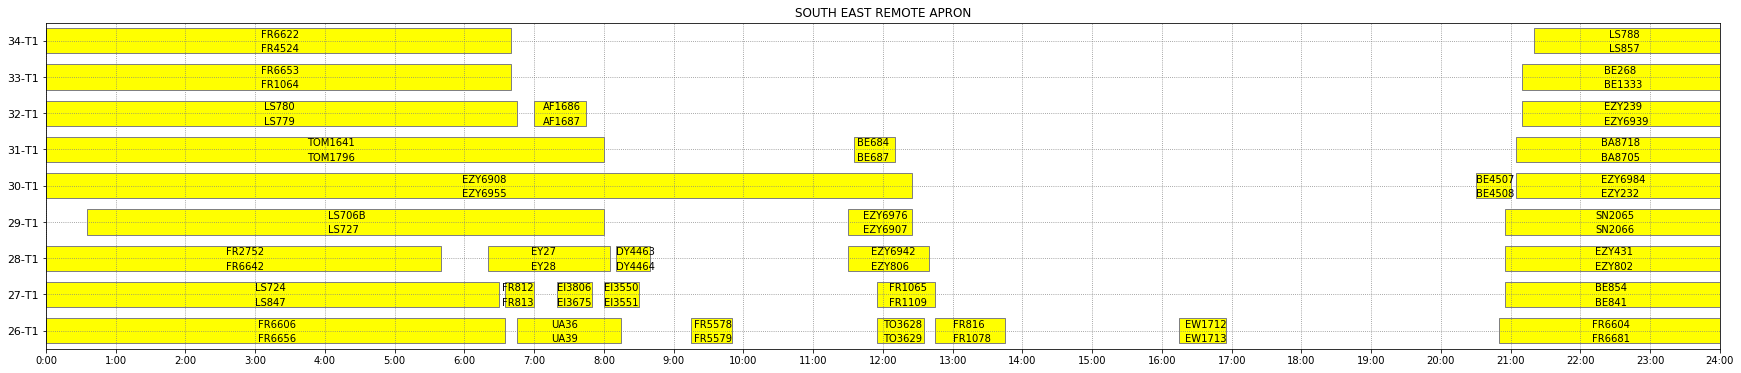

In [96]:
fig = plt.figure(figsize=(30,len(testStands)/1.5))
ax  = fig.add_subplot(111)

hour_labels = [ str(hour) + ':00' for hour in range(0,25)]
pos = arange(0.5,len(testStands) + 0.5,0.5)
ylabels = testStands

ax.grid(color = 'grey', linestyle = ':')

for index, row in testFlights.iterrows(): 
    
    height     = np.where(testStands == row['stand'])[0][0] + 1    
    end_time   = row['DATETIME_y'].hour + float(row['DATETIME_y'].minute) / 60
    start_time = row['DATETIME_x'].hour + float(row['DATETIME_x'].minute) / 60
    
    if row['DATETIME_y'] == max(linked['DATETIME_y']): end_time = end_time + 24
        
    ax.barh(height, end_time - start_time, left=start_time, height=0.7, align='center', \
            color='yellow', linewidth = 1, edgecolor='grey')
    
    text( 0.5*(end_time + start_time) - 0.25, height+0.1, row['SERVICE_x'], fontsize=10)
    text( 0.5*(end_time + start_time) - 0.25, height-0.3, row['SERVICE_y'], fontsize=10)

# Fix y axis
locsy, labelsy = yticks(pos, ylabels)
plt.setp(labelsy, fontsize = 11)

#locsx, labelsx = yticks(pos, ylabels)
ax.set_xticklabels(hour_labels)

# Set x scale to hours from 1 to 24
ax.set_ylim(ymin = 0.5, ymax = len(testStands) + 0.5)
xticks(np.arange(0, 25, step=1))
yticks(np.arange(1, len(testStands) + 1, step=1))
ax.set_xlim(xmin = 0, xmax = 24)

# Set title
plt.title(testGroup)
savefig('180408.png')

plt.show()